In [ ]:
import os
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from random import shuffle
from tensorflow.keras.models import load_model

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
from PIL import Image
%matplotlib inline

print('Using Tensorflow', tf.__version__)

Using Tensorflow 2.7.0


In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
train_covid_dir = '/content/drive/MyDrive/ML Project/Dataset/COVID'
test_covid_dir = '/content/drive/MyDrive/ML Project/Dataset/COVID TEST'
train_normal_dir = '/content/drive/MyDrive/ML Project/Dataset/NORMAL'
test_normal_dir = '/content/drive/MyDrive/ML Project/Dataset/NORMAL TEST'

In [ ]:
IMG_SIZE = 128

# Training Data

In [ ]:
training_data = []

dir = os.listdir(train_covid_dir)
shuffle(dir)
for img in tqdm(dir, total = len(dir) ):
  label = [0, 1] # [normal,covid positive]
  path = os.path.join(train_covid_dir,img)
  img = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  training_data.append([np.array(img),np.array(label)])

shuffle(training_data)

100%|██████████| 600/600 [02:20<00:00,  4.26it/s]


In [ ]:
dir = os.listdir(train_normal_dir)
shuffle(dir)

for img in tqdm(dir, total = len(dir) ):
  label = [1, 0] # [normal,covid positive]
  path = os.path.join(train_normal_dir,img)
  img = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  training_data.append([np.array(img),np.array(label)])

shuffle(training_data)

100%|██████████| 1397/1397 [07:13<00:00,  3.23it/s]


In [ ]:
print(len(training_data))
np.save("/content/drive/MyDrive/ML Project/128_size_models/training_128_128_3",training_data)

1997


# Testing Data

In [ ]:
testing_data = []

dir = os.listdir(test_covid_dir)
shuffle(dir)
for img in tqdm(dir, total = len(dir) ):
  label = [0, 1] # [normal,covid positive]
  path = os.path.join(test_covid_dir,img)
  img = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  testing_data.append([np.array(img),np.array(label)])

shuffle(training_data)

100%|██████████| 62/62 [00:03<00:00, 19.78it/s]


In [ ]:
dir = os.listdir(test_normal_dir)
shuffle(dir)

for img in tqdm(dir, total = len(dir) ):
  label = [1, 0] # [normal,covid positive]
  path = os.path.join(test_normal_dir,img)
  img = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  testing_data.append([np.array(img),np.array(label)])

shuffle(training_data)

100%|██████████| 148/148 [00:38<00:00,  3.86it/s]


In [ ]:
print(len(testing_data))
np.save("/content/drive/MyDrive/ML Project/128_size_models/testing_128_128_3",testing_data)

210


# Check the training and testing files

In [ ]:
data=training_data[0][0]
print(data.shape)
img=Image.fromarray(data)
print(img.mode)
#print(training_data[0][1])

## Images are in RGB format

(128, 128, 3)
RGB


In [ ]:
training_file_path = '/content/drive/MyDrive/ML Project/128_size_models/training_128_128_3.npy'
testing_file_path = '/content/drive/MyDrive/ML Project/128_size_models/testing_128_128_3.npy'

In [ ]:
training_data = []
training_data = np.load(training_file_path,allow_pickle=True)
testing_data = []
testing_data = np.load(testing_file_path,allow_pickle=True)
print(f"Training samples count: {len(training_data)}")
print(f"Testing samples count: {len(testing_data)}")

Training samples count: 1997
Testing samples count: 210


In [ ]:
train_normal, train_covid = np.sum(training_data[:,1],axis=0)
test_normal, test_covid = np.sum(testing_data[:,1],axis=0)

In [ ]:
total = train_normal + train_covid
total += test_normal + test_covid

print(f"No. of Training Covid samples: {train_covid}")
print(f"No. of Training Normal samples: {train_normal}")
print(f"No. of Testing Covid samples: {test_covid}")
print(f"No. of Testing Normal samples: {test_normal}")
print(f"Total count of samples: {total}")

No. of Training Covid samples: 600
No. of Training Normal samples: 1397
No. of Testing Covid samples: 62
No. of Testing Normal samples: 148
Total count of samples: 2207


# Model Build and Train

In [ ]:
training_file_path = '/content/drive/MyDrive/ML Project/128_size_models/training_128_128_3.npy'
testing_file_path = '/content/drive/MyDrive/ML Project/128_size_models/testing_128_128_3.npy'

In [ ]:
training_data = []
training_data = np.load(training_file_path,allow_pickle=True)
testing_data = []
testing_data = np.load(testing_file_path,allow_pickle=True)
print(f"Training samples count: {len(training_data)}")
print(f"Testing samples count: {len(testing_data)}")

Training samples count: 1997
Testing samples count: 210


In [ ]:
IMG_SIZE=128

def load_data():
  X_train=np.array([x[0] for x in training_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
  Y_train=np.array([y[1] for y in training_data])

  X_test=np.array([x[0] for x in testing_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
  Y_test=np.array([y[1] for y in testing_data])

  return (X_train,Y_train),(X_test,Y_test)

In [ ]:
class_names=['Normal','Covid-19']

def show_some_samples(x,y,p):
    indices = np.random.choice(range(len(x)), 10, replace=False)

    x = x[indices] 
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])        
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    
    plt.show()
    

### Some samples from training data

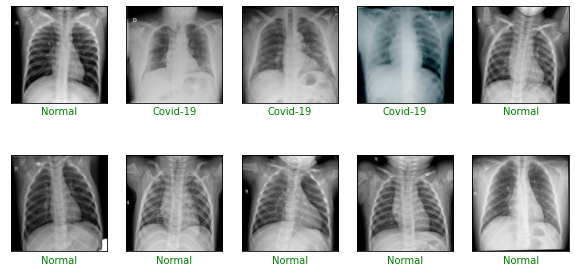

In [ ]:
(X_train,Y_train),(X_test,Y_test)=load_data()

show_some_samples(X_train,Y_train,Y_train)

## Building the model

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 20
BS = 16

#Rescale test and train data
(X_train,Y_train),(X_test,Y_test)=load_data()
X_train=X_train/255
X_test=X_test/255

# construct the training image generator for data augmentation
aug = ImageDataGenerator( 
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
#(X_train, X_val, Y_train, Y_val) = train_test_split(X_train, Y_train, test_size=0.10, stratify=Y_train, random_state=42)

In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are
# left off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(128, 128, 3)), input_shape=(128,128,3))

# construct the head of the model that will be placed on top of the
# the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)

model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False



opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] model is compiled...")


58900480/58889256 [==============================] - 1s 0us/step
[INFO] model is compiled...


### Training

In [ ]:
from keras.callbacks import ModelCheckpoint,TensorBoard
%load_ext tensorboard
!rm -rf ./logs/

In [ ]:
NAME = "VGG_model3_20epoch_128"
log_dir = f"/content/drive/MyDrive/ML Project/LOGS/{NAME}"
tensorboard_callback = TensorBoard(log_dir=log_dir)

In [ ]:
callbacks = [tensorboard_callback]

In [ ]:
# train the head of the network
print("[INFO] training head...")

with tf.device('/device:GPU:0'):
  H = model.fit(
    aug.flow(X_train, Y_train, batch_size=BS),
    steps_per_epoch=len(X_train)//BS ,
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test)//BS ,
    epochs=EPOCHS,
    callbacks=callbacks)

[INFO] training head...
Epoch 1/20
124/124 [==============================] - 29s 143ms/step - loss: 0.3936 - accuracy: 0.8465 - val_loss: 0.2650 - val_accuracy: 0.8619
Epoch 2/20
124/124 [==============================] - 12s 98ms/step - loss: 0.1837 - accuracy: 0.9455 - val_loss: 0.1735 - val_accuracy: 0.9143
Epoch 3/20
124/124 [==============================] - 12s 98ms/step - loss: 0.1375 - accuracy: 0.9561 - val_loss: 0.1385 - val_accuracy: 0.9286
Epoch 4/20
124/124 [==============================] - 12s 95ms/step - loss: 0.1139 - accuracy: 0.9616 - val_loss: 0.1282 - val_accuracy: 0.9333
Epoch 5/20
124/124 [==============================] - 12s 98ms/step - loss: 0.1072 - accuracy: 0.9626 - val_loss: 0.0833 - val_accuracy: 0.9667
Epoch 6/20
124/124 [==============================] - 12s 99ms/step - loss: 0.0955 - accuracy: 0.9687 - val_loss: 0.1271 - val_accuracy: 0.9524
Epoch 7/20
124/124 [==============================] - 12s 98ms/step - loss: 0.0827 - accuracy: 0.9748 - val_los

# Model Performance Analysis

In [ ]:
loss, accuracy = model.evaluate(X_test,Y_test)

print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")

7/7 [==============================] - 7s 504ms/step - loss: 0.0363 - accuracy: 0.9810
Testing Loss: 0.03630710020661354
Testing Accuracy: 0.9809523820877075


Previously trained model metrics:

Testing Loss: 0.059057366102933884

Testing Accuracy: 0.9714285731315613

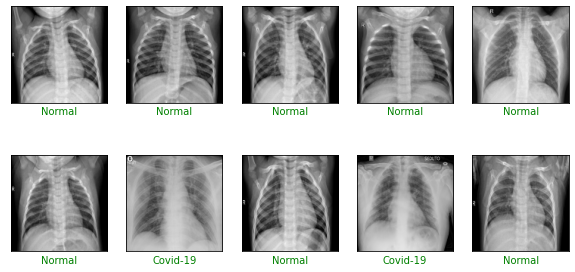

In [ ]:
preds=model.predict(X_test,batch_size=BS)
show_some_samples(X_test,Y_test,preds)

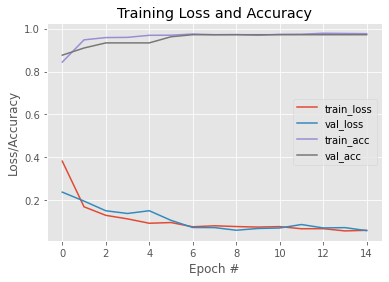

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig('plot.png')

In [ ]:
from sklearn.metrics import classification_report
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(Y_test.argmax(axis=1), predIdxs,
	target_names=['Normal','Covid-19']))

[INFO] evaluating network...
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       148
    Covid-19       0.98      0.95      0.97        62

    accuracy                           0.98       210
   macro avg       0.98      0.97      0.98       210
weighted avg       0.98      0.98      0.98       210



### Metrics

Sensitivity = (True Positive)/(True Positive + False Negative)

Specificity = (True Negative)/(True Negative + False Positive)

Precision =  (True Positives) / (True Positives + False Positives)

Recall =  (True Positives) / (TruePositives + False Negatives)

In [ ]:
cm = confusion_matrix(Y_test.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
#precision = cm[0, 0] / (cm[0, 0] + cm[1, 0])
#recall = cm[0, 0] / (cm[0, 0] + cm[0, 1])


# show the cnfusion matrix, accuracy
#sensitivity, and specificity

print(f"True  positive [normal]: {cm[0][0]}")
print(f"False positive [normal]: {cm[1][0]}")
print(f"True  negative [covid]: {cm[1][1]}")
print(f"False negative [covid]: {cm[0][1]}")


print("\nacc: {:.4f}".format(acc))
print("sensitivity [normal]: {:.4f}".format(sensitivity))
print("specificity [covid]: {:.4f}".format(specificity))
#print("precision: {:.4f}".format(precision))
#print("recall: {:.4f}".format(recall))

True  positive [normal]: 147
False positive [normal]: 3
True  negative [covid]: 59
False negative [covid]: 1

acc: 0.9810
sensitivity [normal]: 0.9932
specificity [covid]: 0.9516


In [ ]:
## Model Save
model.save('/content/drive/MyDrive/ML Project/128_size_models/VGG_model3_128_20ep.h5')

# Model Architecture

In [ ]:
model = load_model('/content/drive/MyDrive/ML Project/128_size_models/VGG_model3_128_20ep.h5')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

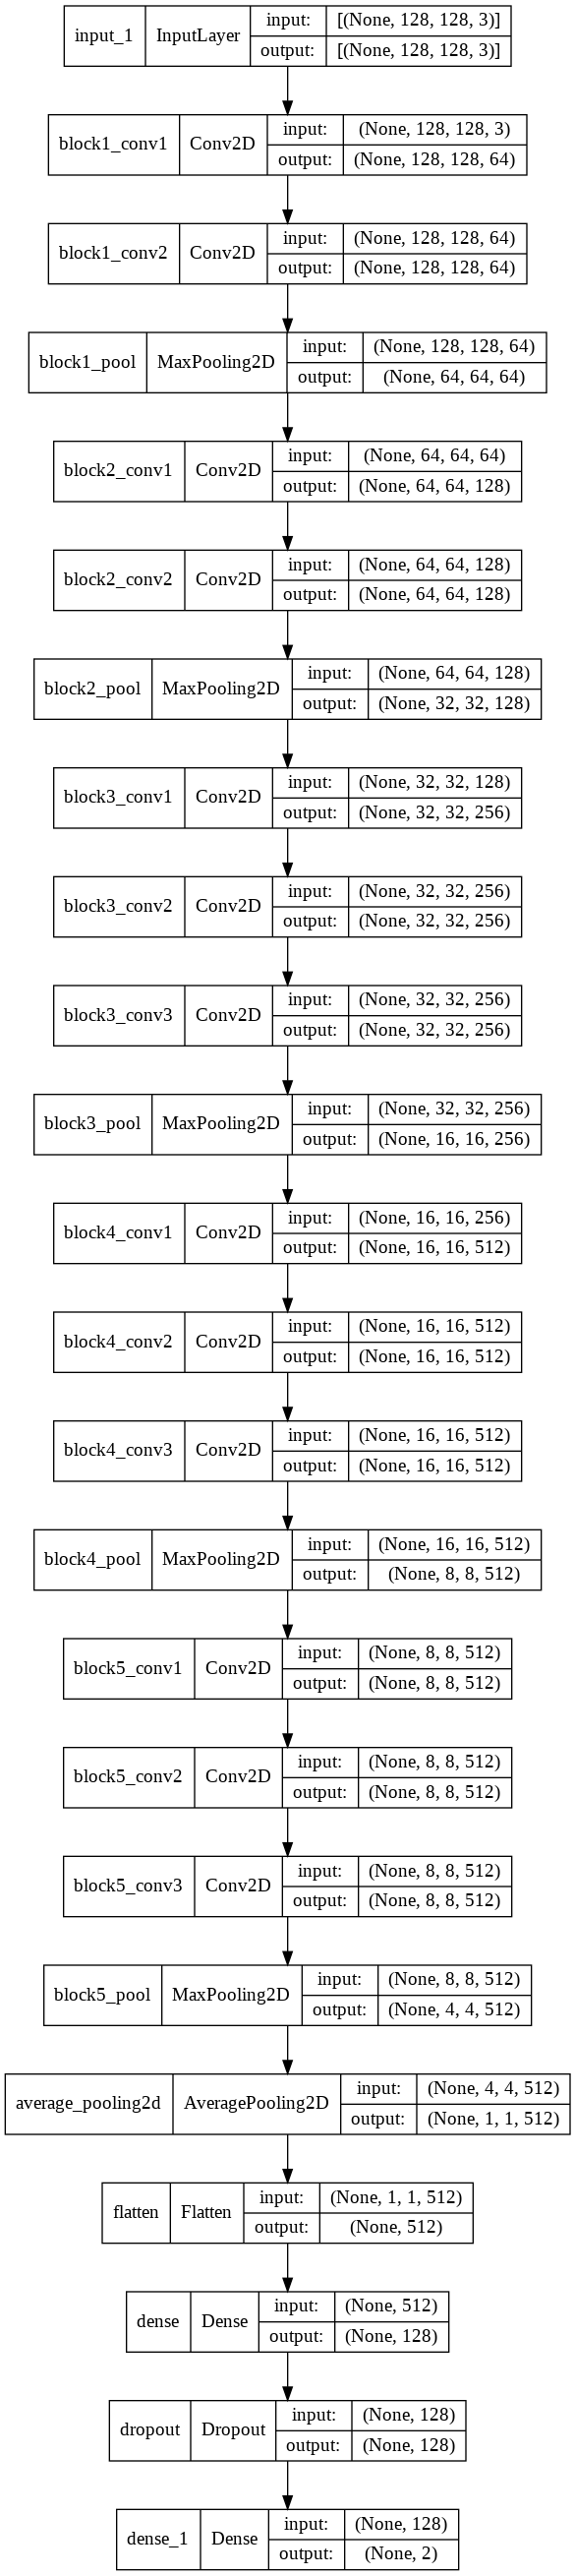

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [1]:
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/ML Project/128_size_models/VGG Model.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/ML Project/128_size_models/VGG Model.ipynb to html
[NbConvertApp] Writing 957986 bytes to /content/drive/MyDrive/ML Project/128_size_models/VGG Model.html
